## CHest 8 Dataset

In [180]:
#Import the dependencies. 
import tensorflow as tf
from keras import backend as K
from keras.models import Sequential
from keras.applications.densenet import DenseNet121
from keras.layers import Dense, GlobalAveragePooling2D
#from tensorflow.keras.optimizers import SGD
from keras.models import Model
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras import regularizers, optimizers
from sklearn.model_selection import train_test_split
from skmultilearn.model_selection import iterative_train_test_split
from sklearn.model_selection import GroupShuffleSplit
from keras.optimizers import SGD, Adam
import keras as K
import numpy as np
import pandas as pd
import sklearn as sklearn
import matplotlib.pyplot as plt
%matplotlib inline
import os
import seaborn as sns
from keras.callbacks import LearningRateScheduler, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard
sns.set()
# Load the TensorBoard notebook extension.
from datetime import datetime
import util
# from tensorflow import keras
# from tensorflow.keras import layers
# from tensorflow.keras.mixed_precision import experimental as mixed_precision

# policy = mixed_precision.Policy('mixed_float16')
# mixed_precision.set_policy(policy)

#import the data
all_data=pd.read_csv('./data/chest8/Data_Entry_2017_v2020.csv')
training_data_path = "data/chest8/images"

In [10]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
      tf.config.experimental.per_process_gpu_memory_fraction = 0.4
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [11]:
#create list of multi-labels
findings_list = all_data['Finding Labels'].apply(lambda x: list(x.split("|")) )

# Converting it into dataframe and working on it seperately
findings_df =pd.DataFrame({"Findings":findings_list})
#findings_df.head()


In [12]:
# importing MultiLabelBinarizer
from sklearn.preprocessing import MultiLabelBinarizer

# instantiating MultiLabelBinarizer
mlb = MultiLabelBinarizer()
findings_encoded = pd.DataFrame(mlb.fit_transform(findings_df["Findings"]),columns=mlb.classes_)
findings_encoded.head()

,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0
2,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


In [13]:
# Concating df and types_encoded
encoded_cxr_data = pd.concat([all_data,findings_encoded], axis = 1)
encoded_cxr_data.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,00000001_000.png,Cardiomegaly,0,1,57,M,PA,2682,2749,0.143,...,0,0,0,0,0,0,0,0,0,0
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,...,1,0,0,0,0,0,0,0,0,0
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,...,0,0,0,0,0,0,0,0,0,0
3,00000002_000.png,No Finding,0,2,80,M,PA,2500,2048,0.171,...,0,0,0,0,0,1,0,0,0,0
4,00000003_001.png,Hernia,0,3,74,F,PA,2500,2048,0.168,...,0,0,1,0,0,0,0,0,0,0


In [14]:
print(encoded_cxr_data.columns)

Index(['Image Index', 'Finding Labels', 'Follow-up #', 'Patient ID',
       'Patient Age', 'Patient Gender', 'View Position', 'OriginalImage[Width',
       'Height]', 'OriginalImagePixelSpacing[x', 'y]', 'Atelectasis',
       'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema',
       'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule',
       'Pleural_Thickening', 'Pneumonia', 'Pneumothorax'],
      dtype='object')


In [15]:
#clean out the input table by droping some columns
encoded_cxr_data=encoded_cxr_data.drop(['Finding Labels', 'Follow-up #',
       'OriginalImage[Width','Height]', 'OriginalImagePixelSpacing[x', 'y]'], axis=1)

encoded_cxr_data_plot=encoded_cxr_data.drop(['Image Index', 'Patient ID', 'Patient Age', 'Patient Gender',
       'View Position'], axis=1)

### Investigate a single image

The dimensions of the image are 1024 pixels width and 1024 pixels height, one single color channel
The maximum pixel value is 1.0000 and the minimum is 0.0000
The mean value of the pixels is 0.4834 and the standard deviation is 0.2577


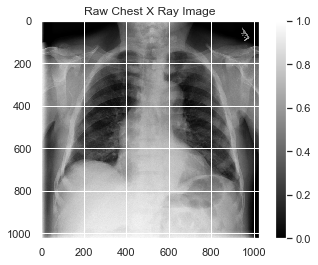

In [9]:
# Get the first image that was listed in the train_df dataframe. The image size is between 390 and 320 pixels. 
sample_img = encoded_cxr_data['Image Index'][30]
raw_image = plt.imread(os.path.join(training_data_path, sample_img))
plt.imshow(raw_image, cmap='gray')
plt.colorbar()
plt.title('Raw Chest X Ray Image')
print(f"The dimensions of the image are {raw_image.shape[0]} pixels width and {raw_image.shape[1]} pixels height, one single color channel")
print(f"The maximum pixel value is {raw_image.max():.4f} and the minimum is {raw_image.min():.4f}")
print(f"The mean value of the pixels is {raw_image.mean():.4f} and the standard deviation is {raw_image.std():.4f}")

In [17]:
#Splits the groups according to patient ID to avoid leakage. 
train_inds,test_inds = next(GroupShuffleSplit(test_size=.20, n_splits=2, random_state = 7).split(encoded_cxr_data, groups=encoded_cxr_data['Patient ID']))
train_df=encoded_cxr_data.iloc[train_inds]
test_df=encoded_cxr_data.iloc[test_inds]

train_inds,val_inds = next(GroupShuffleSplit(test_size=.20, n_splits=2, random_state = 7).split(train_df, groups=train_df['Patient ID']))
val_df=train_df.iloc[val_inds]
train_df=train_df.iloc[train_inds]

In [18]:
def check_for_leakage(df1, df2, patient_col):
    """
    Return True if there any patients are in both df1 and df2.

    Args:
        df1 (dataframe): dataframe describing first dataset
        df2 (dataframe): dataframe describing second dataset
        patient_col (str): string name of column with patient IDs
    
    Returns:
        leakage (bool): True if there is leakage, otherwise False
    """

    df1_id = df1[patient_col].to_numpy()
    df1_id_set = set(df1_id) 
    df2_id = df2[patient_col].to_numpy()
    df2_id_set = set(df2_id)
    
    df1_patients_unique = len(df1_id_set)
    #print("df1 unique", df1_patients_unique)
    df2_patients_unique = len(df2_id_set)
    #print("df2 unique", df2_patients_unique)
    
    patients_in_both_groups = list(df1_id_set.intersection(df2_id_set))
    overlap = len(patients_in_both_groups)
    #print("print overlap", overlap)

    # leakage contains true if there is patient overlap, otherwise false.
    if overlap >0:
        leakage = True
    else: 
        leakage = False
    
    ### END CODE HERE ###
    
    return leakage

In [19]:
#check for leakage in the training and validation sets. 
print("leakage between train and test: {}".format(check_for_leakage(train_df, test_df, 'Patient ID')))
print("leakage between train and val: {}".format(check_for_leakage(train_df, val_df, 'Patient ID')))
print("leakage between val and test: {}".format(check_for_leakage(val_df, test_df, 'Patient ID')))

leakage between train and test: False
leakage between train and val: False
leakage between val and test: False


In [20]:
train_df.columns

Index(['Image Index', 'Patient ID', 'Patient Age', 'Patient Gender',
       'View Position', 'Atelectasis', 'Cardiomegaly', 'Consolidation',
       'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration',
       'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia',
       'Pneumothorax'],
      dtype='object')

In [21]:
train_labels=train_df.drop(['Image Index', 'Patient ID', 'Patient Age', 'Patient Gender',
       'View Position'], axis=1)

In [22]:
labels=['Atelectasis', 'Cardiomegaly', 'Consolidation',
       'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration',
       'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia',
       'Pneumothorax']

In [60]:
#Create a class labels dictornary for Keras. 

from sklearn.utils import class_weight

y_train=train_labels.values
y_ints = [y.argmax() for y in y_train]

sample_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_ints),
                                                 y_ints)
class_weight_dict = dict(enumerate(class_weights))

#class_weights = compute_sample_weight('balanced', np.unique(y_integers), y_integers)
#d_class_weights = dict(enumerate(class_weights))

In [70]:
class_weight = [{0:1, 1: 0.6491961561233319},{0:1, 1: 3.2768735632183907}, {0:1,1: 2.317788617886179},{0:1, 1: 4.0403628117913835}, {0:1,1: 0.9472620946305157}, {0:1,1: 4.1353060632434}, {0:1,1: 6.052823779193206}, {0:1,1: 47.99461279461279}, {0:1,1: 0.6409640721255452}, {0:1,1: 2.48118363794604}, {0:1,1: 0.12321629237764294}, {0:1,1: 2.447947793233728}, {0:1,1: 6.343747218513574}, {0:1,1: 21.307025411061286}, {0:1,1: 3.334362573099415}]

In [61]:
print(sample_weights)

[ 0.64919616  3.27687356  2.31778862  4.04036281  0.94726209  4.13530606
  6.05282378 47.99461279  0.64096407  2.48118364  0.12321629  2.44794779
  6.34374722 21.30702541  3.33436257]


In [23]:
def get_train_generator(df, image_dir, x_col, y_cols, shuffle=True, batch_size=4, seed=1, target_w = 256, target_h = 256):
    """
    Return generator for training set, normalizing using batch
    statistics.

    Args:
      train_df (dataframe): dataframe specifying training data.
      image_dir (str): directory where image files are held.
      x_col (str): name of column in df that holds filenames.
      y_cols (list): list of strings that hold y labels for images.
      sample_size (int): size of sample to use for normalization statistics.
      batch_size (int): images per batch to be fed into model during training.
      seed (int): random seed.
      target_w (int): final width of input images.
      target_h (int): final height of input images.
    
    Returns:
        train_generator (DataFrameIterator): iterator over training set
    """        
    print("getting train generator...") 
    # normalize images
    image_generator = ImageDataGenerator(
        samplewise_center=True,
        samplewise_std_normalization= True)
    
    # flow from directory with specified batch size
    # and target image size
    generator = image_generator.flow_from_dataframe(
            dataframe=df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=shuffle,
            seed=seed,
            target_size=(target_w,target_h))
    
    return generator

In [49]:
def get_test_and_valid_generator(valid_df, test_df, train_df, image_dir, x_col, y_cols, sample_size=100, batch_size=4, seed=1, target_w = 256, target_h = 256):
    """
    Return generator for validation set and test test set using 
    normalization statistics from training set.

    Args:
      valid_df (dataframe): dataframe specifying validation data.
      test_df (dataframe): dataframe specifying test data.
      train_df (dataframe): dataframe specifying training data.
      image_dir (str): directory where image files are held.
      x_col (str): name of column in df that holds filenames.
      y_cols (list): list of strings that hold y labels for images.
      sample_size (int): size of sample to use for normalization statistics.
      batch_size (int): images per batch to be fed into model during training.
      seed (int): random seed.
      target_w (int): final width of input images.
      target_h (int): final height of input images.
    
    Returns:
        test_generator (DataFrameIterator) and valid_generator: iterators over test set and validation set respectively
    """
    print("getting train and valid generators...")
    # get generator to sample dataset
    raw_train_generator = ImageDataGenerator().flow_from_dataframe(
        dataframe=train_df, 
        directory=image_dir, 
        x_col=x_col, 
        y_col=labels, 
        class_mode="raw", 
        batch_size=sample_size, 
        shuffle=True, 
        target_size=(target_w, target_h))
    
    # get data sample
    batch = raw_train_generator.next()
    data_sample = batch[0]

    # use sample to fit mean and std for test set generator
    image_generator = ImageDataGenerator(
        featurewise_center=True,
        featurewise_std_normalization= True)
    
    # fit generator to sample from training data
    image_generator.fit(data_sample)

    # get test generator
    valid_generator = image_generator.flow_from_dataframe(
            dataframe=valid_df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=False,
            seed=seed,
            target_size=(target_w,target_h))

    test_generator = image_generator.flow_from_dataframe(
            dataframe=test_df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=False,
            seed=seed,
            target_size=(target_w,target_h))
    return valid_generator, test_generator

In [50]:
train_generator = get_train_generator(train_df, training_data_path, "Image Index", labels)
valid_generator, test_generator= get_test_and_valid_generator(val_df, test_df, train_df, training_data_path, "Image Index", labels)

getting train generator...
Found 71272 validated image filenames.
getting train and valid generators...
Found 71272 validated image filenames.
Found 18123 validated image filenames.
Found 22725 validated image filenames.


In [34]:
def gen_wrapper(generator):
    for batch_x,batch_y in generator:
        yield (batch_x,[batch_y[:,i] for i in range(15)])

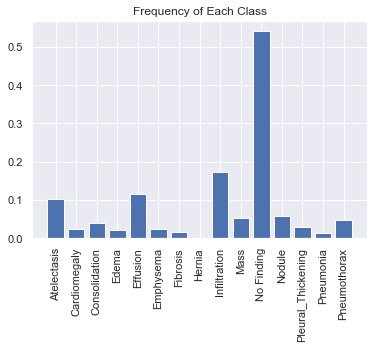

In [25]:
plt.xticks(rotation=90)
plt.bar(x=labels, height=np.mean(train_generator.labels, axis=0))
plt.title("Frequency of Each Class")
plt.show()

## Build the model

In [187]:
backbone = DenseNet121(
    include_top=False,
    input_shape=(256, 256, 3),
    weights= None
)

neck = GlobalAveragePooling2D()(backbone.output)

def build_tower(in_layer):
    neck = BatchNormalization()(in_layer)
    neck = Dropout(0.1)(neck)
    neck = Dense(128, activation='relu')(neck)
    return neck

#This can be created into a class in the future. 
def build_head(name, in_layer):
    return Dense(2, activation='softmax', name=f'{name}_output')(in_layer)
#return Dense(num_units[name], activation='softmax', name=f'{name}_output')(in_layer)

#heads
atelectasis = build_head("atelectasis", build_tower(neck))
cardiomegaly = build_head("cardiomegaly", build_tower(neck))
consolidation = build_head("consolidation", build_tower(neck))
edema = build_head("edema", build_tower(neck))
effusion = build_head("effusion", build_tower(neck))
emphysema = build_head("emphysema", build_tower(neck))
fibrosis = build_head("fibrosis", build_tower(neck))
hernia = build_head("hernia", build_tower(neck))
infiltration = build_head("infiltration", build_tower(neck))
mass = build_head("mass", build_tower(neck))
no_finding = build_head("no_finding", build_tower(neck))
nodule = build_head("nodule", build_tower(neck))
pleural_thickening = build_head("pleural_thickening", build_tower(neck))
pneumonia = build_head("pneumonia", build_tower(neck))
pneumothorax = build_head("pneumothorax", build_tower(neck))

model = Model(
    inputs=backbone.input,
    outputs=[atelectasis, cardiomegaly, consolidation, edema,\
             effusion, emphysema, fibrosis,hernia, infiltration,mass, \
             no_finding, nodule, pleural_thickening, pneumonia, \
             pneumothorax]
)

In [43]:
#model.summary()

In [188]:
# reduce lr on plateau
reduce_lr_on_plateau = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.7,
    patience=3,
    min_lr=1e-6,
    verbose=1,
    min_delta=1e-3
)

# save the model
save_dir = os.path.join(os.getcwd(), '.\data\chest8\model')
model_name = 'cxr_multitask_v2.h5'

if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

# checkpoint callback
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True)

# Early Stopping
early_stopping = EarlyStopping(
    patience=8,
    verbose=1,
    min_delta=1e-3,
    restore_best_weights=True
)

METRICS = [
      #K.metrics.TruePositives(name='tp'),
      #K.metrics.FalsePositives(name='fp'),
      #K.metrics.TrueNegatives(name='tn'),
      #K.metrics.FalseNegatives(name='fn'), 
      #K.metrics.BinaryAccuracy(name='accuracy'),
      #K.metrics.Precision(name='precision'),
      #K.metrics.Recall(name='recall'),
      K.metrics.AUC(name='auc'),
]

#setup tensorboard
#create the logs direectory.
log_dir = os.path.join(
    "logs",
    "fit",
    datetime.now().strftime("%Y%m%d-%H%M%S"),
)
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

In [189]:
def compile_model(model):
    model.compile(
        optimizer=Adam(lr=9e-4),
        loss='categorical_crossentropy',
        metrics=METRICS
    )

In [190]:
def freeze_model(model: K.Model):
    for l in model.layers:
        l.trainable = False

def unfreeze_model(model: K.Model):
    for l in model.layers:
        l.trainable = True

def print_layer_name_and_trainability(model: K.Model):
    for l in model.layers:
        print(l.name, l.trainable)
        
def check_all_layers_trainable(model):
    # skip the input layer
    for l in model.layers[1:]:
        assert l.trainable == True, "Complete Model is not trainable"

In [168]:
def show_results(model: K.Model, show_loss=False):
    data = []
    results = model.evaluate_generator(gen_wrapper(valid_generator), verbose=1)
    for m, r in zip(model.metrics_names, results):
        if show_loss:
            data.append({'metric_name': m, 'auc': r})            
        
        elif 'acc' in m:
                data.append({'metric_name': m, 'auc': r})
    
    df = pd.DataFrame(data, columns=['metric_name', 'auc'])
    print(df)

In [65]:
model.load_weights('.\data\chest8\model\cxr_multitask.h5')

In [191]:
for l in model.layers:
    l.trainable = True

check_all_layers_trainable(model)

In [192]:
compile_model(model)

# for 50 epochs train on (100, 100, 3), with adam defaults, reduce_lr and no data augmentation
H = model.fit_generator(
    generator=gen_wrapper(train_generator),
    validation_data=gen_wrapper(valid_generator),
    steps_per_epoch=train_generator.n//train_generator.batch_size,
    validation_steps=valid_generator.n//valid_generator.batch_size,
    epochs=5,
    verbose=1,
    class_weight=class_weight,
    callbacks=[reduce_lr_on_plateau, checkpoint, early_stopping]
)

Epoch 1/5


ValueError: Error when checking target: expected atelectasis_output to have shape (2,) but got array with shape (1,)

In [108]:
# plot the training + testing loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 15), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, 15), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, 15), H.history["accuracy"], label="acc")
plt.plot(np.arange(0, 15), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()

NameError: name 'H' is not defined

<Figure size 432x288 with 0 Axes>

In [139]:
compile_model(model)
model.load_weights('.\data\chest8\model\cxr_multitask.h5')

In [140]:
#test_generator.reset()
predictions_2 = model.predict(gen_wrapper(test_generator), steps = len(test_generator), verbose = 1)

5682/5682 [==============================] - 318s 56ms/step


In [142]:
# predictions
# new_predictions= np.concatenate(predictions,axis=1)
new_predictions[3]

array([1.0099265e-03, 9.9101318e-03, 1.2399997e-03, 3.6987389e-04,
       2.0187066e-03, 2.1588267e-03, 8.8074431e-02, 6.5691466e-07,
       6.0438372e-02, 2.5144642e-02, 3.0184484e-01, 1.0122281e-01,
       7.8367420e-02, 4.4442933e-02, 1.2092470e-02], dtype=float32)

In [51]:
auc_rocs = sklearn.metrics.roc_auc_score(test_generator.labels, predicted_vals)

ValueError: Found array with dim 3. Estimator expected <= 2.

In [76]:
test = gen_wrapper(test_generator.labels)

In [133]:
test_generator.labels[1]

array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0])

In [128]:
#predicted_vals
#This converts the tensoflow output of a list of arrays to a numpy array as is the input from
#test_pred = np.concatenate(predicted_vals,axis=1)
test_pred[74]
#labels[test_pred[1].argmax()]

array([6.1109946e-03, 7.6362854e-03, 8.8395728e-03, 3.3911847e-02,
       1.7331025e-02, 3.7069801e-02, 3.9044168e-02, 3.8163854e-08,
       1.3764726e-01, 6.6312172e-02, 1.9520175e-01, 1.0190491e-01,
       1.4747383e-01, 5.2858446e-02, 1.5519162e-01], dtype=float32)